In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
import time

## The HDF5 event files
The dataframes (called 'Particles') are stored in HDF5 files. There is one file for simulated 2vbb events, and one file for simulated background events. The backrounds simulated are Tl208, Bi214, Co60, and K40.

For the backgrounds, there is one entry per event, and for 2vbb, there are two entries per event (one for each primary electron). All of the 2vbb events can be keyed by the 'event' attribute, which is unique.

In [2]:
'''
Load in dataframe:
'''

fname = './files/Xe2nu_NEW_1d_brem.h5'
df_particles = pd.read_hdf(fname, 'Particles')

In [3]:
'''
Look at which variables are stored in BG the dataframe:
'''
print('True background variables:')
print(df_particles.columns.tolist()[:8])
print()
print('Reconstructed background variables:')
print(df_particles.columns.tolist()[8:])

True background variables:
['particle_indx', 'particle_name', 'primary', 'kin_energy', 'creator_proc', 'initial_x', 'initial_y', 'initial_z']

Reconstructed background variables:
['final_x', 'final_y', 'final_z', 'momentum_x', 'momentum_y', 'momentum_z', 'momentum', 'event', 'evt_energy', 'n_brems', 'opening_angle', 'mcs_angle', 'e_displacement', 'nS2', 'reco_energy', 'reco_length', 'reco_numb_of_tracks', 'reco_x_min', 'reco_y_min', 'reco_z_min', 'reco_r_min', 'reco_x_max', 'reco_y_max', 'reco_z_max', 'reco_r_max', 'reco_x_ave', 'reco_y_ave', 'reco_z_ave', 'reco_r_ave', 'reco_extreme1_x', 'reco_extreme1_y', 'reco_extreme1_z', 'reco_extreme2_x', 'reco_extreme2_y', 'reco_extreme2_z', 'reco_blob1_x', 'reco_blob1_y', 'reco_blob1_z', 'reco_blob2_x', 'reco_blob2_y', 'reco_blob2_z', 'reco_eblob1', 'reco_eblob2', 'reco_ovlp_blob_energy']


# Analysis cuts:
Recreate the NEXT NEW 2vbb analysis cuts:<br>
<img src="images/slide_procedure.png" width=600><br>
From Alberto's CM slides: <br>
https://next.ific.uv.es/DocDB/0009/000981/001/MC-data_efficiencies_studies_MC_november.pdf

In [4]:
'''
Make fiducial and S2 cuts for all data:
'''

df_particles = df_particles[(df_particles['nS2'] == 1)&(df_particles['reco_z_min'] > 20)&(df_particles['reco_z_max'] < 510)&(df_particles['reco_r_max'] < 178)]

In [5]:
'''
Make remaining analysis cuts here:
'''

df_particles_selection = df_particles[(df_particles['reco_numb_of_tracks'] == 1)&(df_particles['reco_ovlp_blob_energy'] == 0.0)
                                      &(df_particles['reco_eblob2']*1000 > 355.55*(1-np.exp(-0.00133*df_particles['reco_energy']*1000)))]
print('Background selection efficiency: %s'%(len(df_particles_selection)/len(df_particles)))

Background selection efficiency: 0.3000153570749127


# Reconstructed energy distribution  event selection

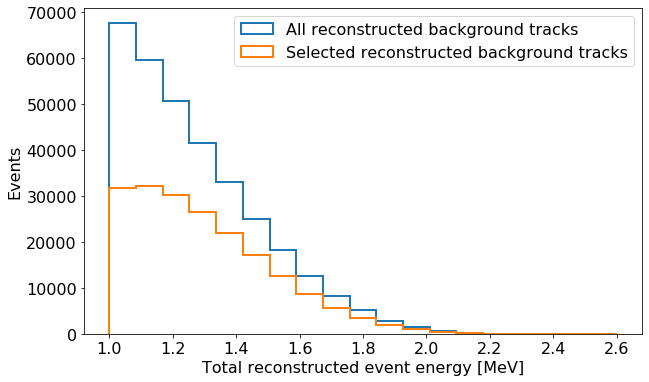

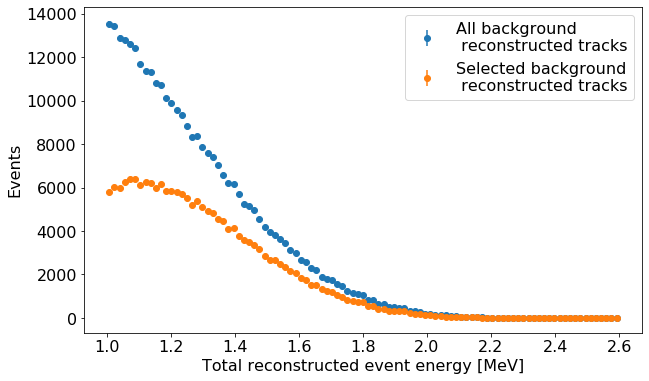

In [6]:
'''
Plot the energy of the reconstructed tracks before and after selection.
'''

plt.figure(figsize=(10,6))

ebins = np.linspace(1,2.6,20)
plt.hist(df_particles['reco_energy'], bins=ebins, histtype='step', lw=2, label='All reconstructed background tracks');
plt.hist(df_particles_selection['reco_energy'], bins=ebins, histtype='step', lw=2, label='Selected reconstructed background tracks');

plt.xlabel('Total reconstructed event energy [MeV]', fontsize=16)
plt.ylabel('Events', fontsize=16)
plt.tick_params(which='major', axis='both', labelsize=16)

plt.legend(loc='upper right', fontsize=16)


plt.figure(figsize=(10,6))

ebins = np.linspace(1,2.6,100)
bin_centers = (ebins[1:] + ebins[:-1])/2
energy_counts,_ = np.histogram(df_particles['reco_energy'], bins=ebins)
energy_counts_selection,_ = np.histogram(df_particles_selection['reco_energy'], bins=ebins)

plt.errorbar(bin_centers, energy_counts, yerr=np.sqrt(energy_counts), fmt='o', label='All background\n reconstructed tracks');
plt.errorbar(bin_centers, energy_counts_selection, yerr=np.sqrt(energy_counts_selection), fmt='o', label='Selected background\n reconstructed tracks');

plt.xlabel('Total reconstructed event energy [MeV]', fontsize=16)
plt.ylabel('Events', fontsize=16)
plt.tick_params(which='major', axis='both', labelsize=16)

plt.legend(loc='upper right', fontsize=16)

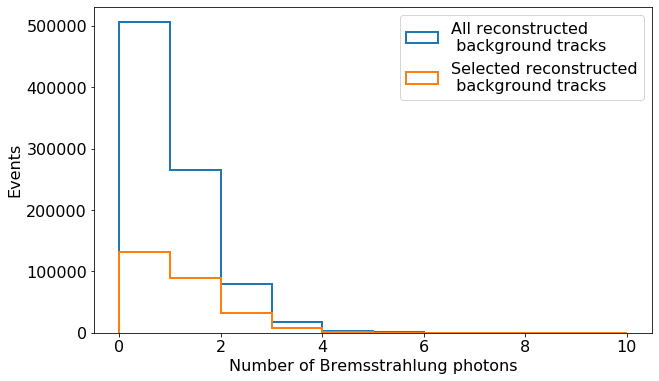

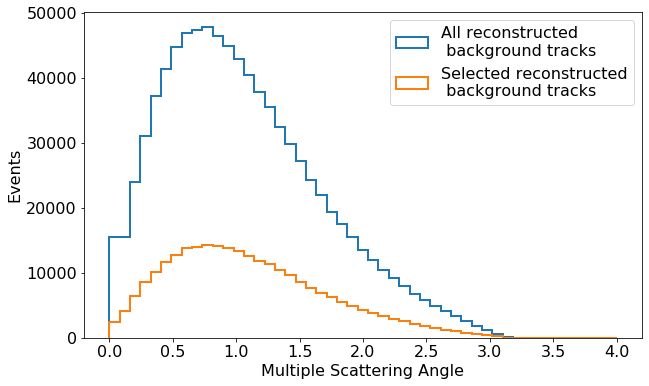

In [7]:
'''
Plot some MC true variables.
'''

plt.figure(figsize=(10,6))

brbins = np.linspace(0,10,11)
plt.hist(df_particles['n_brems'], bins=brbins, histtype='step', lw=2, label='All reconstructed\n background tracks');
plt.hist(df_particles_selection['n_brems'], bins=brbins, histtype='step', lw=2, label='Selected reconstructed\n background tracks');

plt.xlabel(r'Number of Bremsstrahlung photons', fontsize=16)
plt.ylabel('Events', fontsize=16)
plt.tick_params(which='major', axis='both', labelsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.figure(figsize=(10,6))

mcsbins = np.linspace(0,4,50)

plt.hist(df_particles['mcs_angle'], bins=mcsbins, histtype='step', lw=2, label='All reconstructed\n background tracks');
plt.hist(df_particles_selection['mcs_angle'], bins=mcsbins, histtype='step', lw=2, label='Selected reconstructed\n background tracks');

plt.xlabel(r'Multiple Scattering Angle', fontsize=16)
plt.ylabel('Events', fontsize=16)
plt.tick_params(which='major', axis='both', labelsize=16)

plt.legend(loc='upper right', fontsize=16)



### eplot
<br>
The following cell is a function called "eplot" and is used to plot the reconstructed energy whether it be selected or not selected with whatever set of weights necessary. To use it you must define whether you want to plot the selected reconstructed energy or total reconstructed energy in the reco_energy spot, and then input the weight vector to pair with it, then the sample size variable used, and finally a string that names the physics variable being studied.

In [8]:
def eplot(reco_energy, weight, sample_size, name):
    
    fig, ax = plt.subplots(nrows=2, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    ebins = np.linspace(1,2.6,100)
    bin_centers = (ebins[1:] + ebins[:-1])/2
    energy_counts,_ = np.histogram(reco_energy, bins=ebins)

    #Creating matrices for the total and average histogram counts
    energy_counts_reweight_all = np.zeros((sample_size,len(energy_counts)))
    energy_counts_reweight = np.zeros(len(energy_counts))

    #For loop that stores the histogram values for the counts into the previously created matrices
    for i in range(0,sample_size):
        energy_counts_reweight_hist,_ = np.histogram(reco_energy, bins=ebins, weights=weight[i])
        energy_counts_reweight_all[i] = energy_counts_reweight_hist

    #Calcluates the average of all the values and stores that into the energy_counts_reweight matrix
    energy_counts_reweight = energy_counts_reweight_all.mean(0)
    #Calculates the standard deviation of the calculated values and the sqrt of the counts for the total error
    yerr_tot = energy_counts_reweight_all.std(0) + np.sqrt(energy_counts_reweight)

    # Reweighted Counts
    ax[0].errorbar(bin_centers, energy_counts_reweight, yerr=yerr_tot, fmt='o', label='Reweighted\n reconstructed\n background tracks\n w/ systematic uncertainty');
    #Original counts - Not Reweighted
    ax[0].errorbar(bin_centers, energy_counts, yerr=np.sqrt(energy_counts), fmt='^', label='Reconstructed\n background tracks');

    ax[1].plot(bin_centers, energy_counts_reweight_all.std(0)/energy_counts_reweight, label='Systematic')
    ax[1].plot(bin_centers, np.sqrt(energy_counts_reweight_all.mean(0))/energy_counts_reweight_all.mean(0), label='Statistical')

    ax[1].set_xlabel('Total reconstructed event energy [MeV]', fontsize=16)
    ax[0].set_ylabel('Events', fontsize=16)
    ax[1].set_ylabel('Fractional \nUncertainty', fontsize = 16)
    ax[0].tick_params(which='major', axis='both', labelsize=16)
    ax[0].set_title('Effect of ' + name +'\n', fontweight = 'bold', fontsize = 25)

    ax[0].legend(loc='upper right', fontsize=16)
    ax[1].legend(loc='upper left', fontsize=16)

    print('Uncertainty:', yerr_tot[70]/energy_counts_reweight[70])

### Brem Weight Calculation
The following calculation uses two stages of for loops to randomly select variables that are used to perform the calculation with, this random sampling should eliminate the uncertainty/bias in the calculation as best as possible. 
<br>
<br>
The first loop selects a random systematic uncertainty for the weight calculation from a normal distribution situated around 0 with a width of 0.1, giving basically a random systematic uncertainty in the range of +/- 10%.
<br>
<br>
The first for loop also randomaly selects a width for which the energy bins can be sliced into several chunks of bins. This should eliminate any energy bias in the calculation. 
<br>
<br>
The second for loop calculates the weights of the events based on the radomly selected systematic uncertainty and runs through the loop however many times is necessary to calculate the weight of every bin using the slice width that was selected.
<br>
To calculate the weights, we take the ratio of Poisson's with the new rate to the old rate:
<br><br>
$w_k = \frac{f_1(k)}{f_0(k)} = e^{-(\lambda_1 - \lambda_0)}(\frac{\lambda_1}{\lambda_0})^k$.
<br><br>
where $\lambda_1 = \lambda_0(1 \pm Systematic Uncertainty)$ 
<br>
<br>
The first for loop for selecting the sample size can be run as many times as is necessary, however a sample size of around 2800 to 3000 is where the ending values tend to be very steady. 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.pe

Time Elapsed: 2192.3991366


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Uncertainty: 0.15999014506578416
Uncertainty: 0.21354221881209925
Uncertainty: 0.2867615842103608


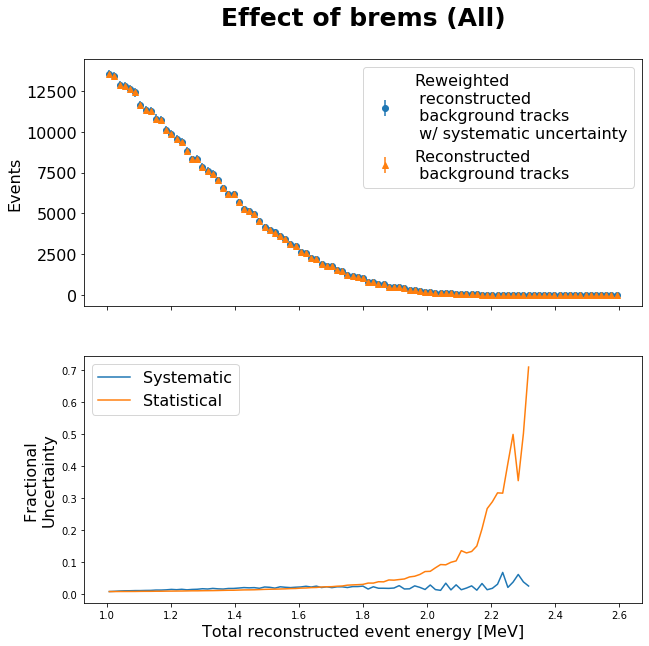

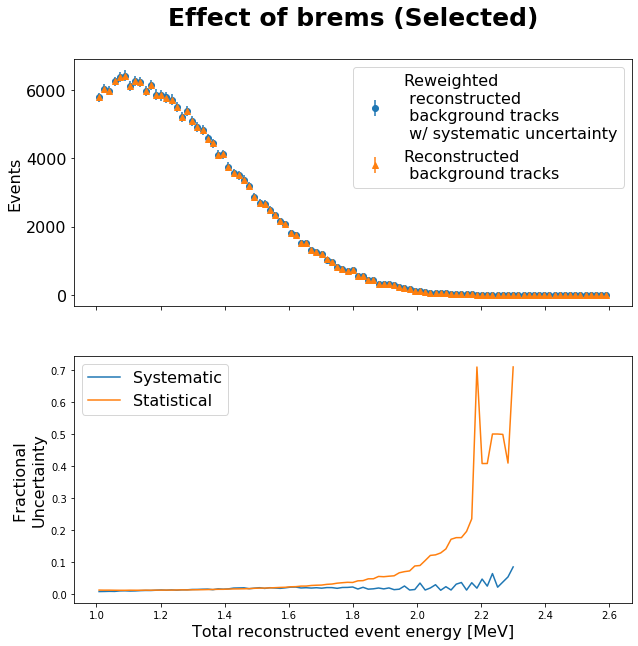

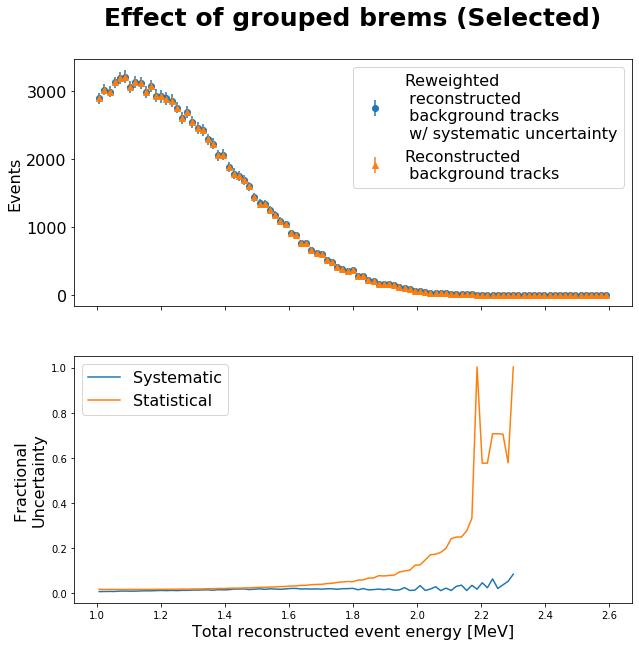

In [12]:
t0 = time.clock()
grouped_particles_selection = df_particles_selection.groupby('event').first()
#creating the matrix to hold the weights
sample_size = 2000
weight_all = np.zeros((sample_size,len(df_particles['n_brems'])))
weight_all_selection = np.zeros((sample_size,len(df_particles_selection['n_brems'])))
weight_all_selection_g = np.zeros((sample_size,len(grouped_particles_selection['n_brems'])))

#Begin for loop that calculates the weights for each randomly selected uncertainty from 1% - 10% and randomly selected bin width from .2 to 2
for j in range(0,sample_size):
    syst_unc = np.random.normal(0, 0.1)
    eslice_width = np.random.uniform()*(2-.2)+.2
    ebins = np.arange(0, 4.0, eslice_width)
    ebins[-1] = 100
    for i in range(len(ebins)-1):
        eslice = (df_particles['reco_energy'] >= ebins[i])&(df_particles['reco_energy'] < ebins[i+1])
        eslice_grouped = (grouped_particles_selection['reco_energy'] >= ebins[i])&(grouped_particles_selection['reco_energy'] < ebins[i+1])
        rate0 = df_particles[eslice]['n_brems'].mean()
        rate1 = rate0*(1 + syst_unc)
        df_particles.loc[eslice, 'weight'] = np.exp(-(rate1-rate0))*(rate1/rate0)**df_particles[eslice]['n_brems']
        df_particles_selection.loc[eslice, 'weight'] = np.exp(-(rate1-rate0))*(rate1/rate0)**df_particles_selection[eslice]['n_brems']
        grouped_particles_selection.loc[eslice_grouped, 'weight'] = np.exp(-(rate1-rate0))*(rate1/rate0)**grouped_particles_selection[eslice_grouped]['n_brems']

    #stores the weights for an uncertainty
    weight_all[j] = df_particles['weight']
    weight_all_selection[j] = df_particles_selection['weight']
    weight_all_selection_g[j] = grouped_particles_selection['weight']

t1 = time.clock()-t0
print('Time Elapsed:', t1)
eplot(df_particles['reco_energy'], weight_all, sample_size, 'brems (All)')
eplot(df_particles_selection['reco_energy'], weight_all_selection, sample_size, 'brems (Selected)')
eplot(grouped_particles_selection['reco_energy'], weight_all_selection_g, sample_size, 'grouped brems (Selected)')

## Mulitple Scattering Angle

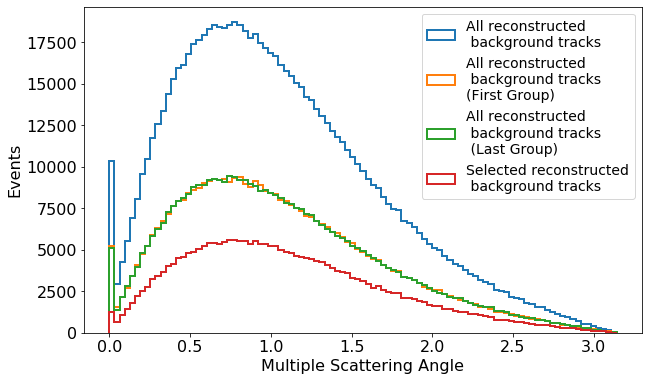

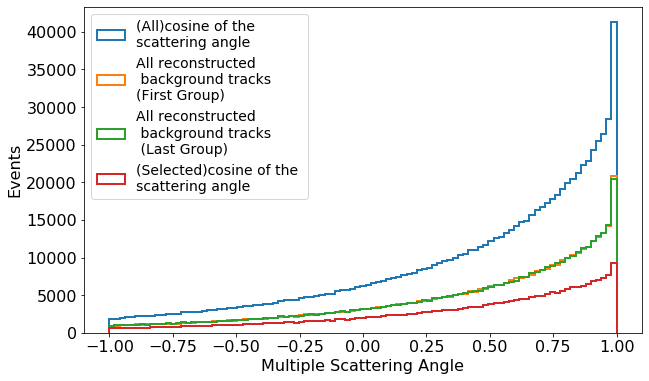

In [13]:
plt.figure(figsize=(10,6))

mcsbins = np.linspace(0,np.pi,100)
mcscosbins = np.linspace(-1,1,100)

plt.hist(df_particles['mcs_angle'], bins=mcsbins, histtype='step', lw=2, label='All reconstructed\n background tracks');
plt.hist(df_particles.groupby('event')['mcs_angle'].first(), bins=mcsbins, histtype='step', lw=2, label='All reconstructed\n background tracks \n(First Group)');
plt.hist(df_particles.groupby('event')['mcs_angle'].last(), bins=mcsbins, histtype='step', lw=2, label='All reconstructed\n background tracks\n (Last Group)');
plt.hist(df_particles_selection['mcs_angle'], bins=mcsbins, histtype='step', lw=2, label='Selected reconstructed\n background tracks');

plt.xlabel(r'Multiple Scattering Angle', fontsize=16)
plt.ylabel('Events', fontsize=16)
plt.tick_params(which='major', axis='both', labelsize=16)

plt.legend(loc='upper right', fontsize=14)

plt.figure(figsize=(10,6))

plt.hist(np.cos(df_particles['mcs_angle']), bins=mcscosbins, histtype='step', lw=2, label='(All)cosine of the \nscattering angle');
plt.hist(np.cos(df_particles.groupby('event')['mcs_angle'].first()), bins=mcscosbins, histtype='step', lw=2, label='All reconstructed\n background tracks \n(First Group)');
plt.hist(np.cos(df_particles.groupby('event')['mcs_angle'].last()), bins=mcscosbins, histtype='step', lw=2, label='All reconstructed\n background tracks\n (Last Group)');
plt.hist(np.cos(df_particles_selection['mcs_angle']), bins=mcscosbins, histtype='step', lw=2, label='(Selected)cosine of the \nscattering angle');

plt.xlabel(r'Multiple Scattering Angle', fontsize=16)
plt.ylabel('Events', fontsize=16)
plt.tick_params(which='major', axis='both', labelsize=16)

plt.legend(loc='upper left', fontsize=14)



### Multiple Coulomb Scattering Weight Calculation
<br>
The cell below calculates the weights by shifting the multiple scattering angle up or down by some fraction (syst_unc). The weight is calculated by removing that fraction of events:
<br><br>
$ 1.0*(1-sys\_unc)$
<br><br>
and adding it to the adjacent bin:
<br><br>
$\frac{mcs\_counts[i\pm1]}{mcs\_counts[i]}*sys\_unc$
<br><br>
If the sys_unc is positive the fraction of events are added to the [ i-1 ] bin and if the sys_unc is negative the fraction of events is added to the [ i+1 ] bin.
<br>
<br>
To calculate the weight due to the multiple scattering angle an overall uncertainty of 10% was used.

In [16]:
# fig, ax = plt.subplots(nrows=2, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

particles_group1 = df_particles.groupby('event').first()
particles_group2 = df_particles.groupby('event').last()
particles_selection_group1 = df_particles_selection.groupby('event').first()
particles_selection_group2 = df_particles_selection.groupby('event').last()

sample_size = 2000

def mcs_weight(particles):
    
    weight_mcs = np.zeros((sample_size, len(particles['mcs_angle'])))

    for j in range(0,sample_size):
        syst_unc = np.random.normal(0, 0.1)
        bin_width = np.random.uniform()*(.05-.01)+.01

        mcsbins = np.arange(0, 3.15, bin_width)

        particles['weight_mcs'] = 1.

        mcs_counts,_ = np.histogram(particles['mcs_angle'], bins=mcsbins)
        weight_vec = np.ones(len(mcsbins) - 1)

        for i in range(len(mcsbins) - 1):
            bin_slice = (particles['mcs_angle'] >= mcsbins[i])&(particles['mcs_angle'] < mcsbins[i+1])
            if syst_unc > 0 and i != 0:
                particles.loc[bin_slice, 'weight_mcs'] = (1-syst_unc) + mcs_counts[i-1]/mcs_counts[i]*syst_unc
                weight_vec[i] = (1-syst_unc) + mcs_counts[i-1]/mcs_counts[i]*syst_unc
            elif syst_unc <= 0 and i+1 != len(mcs_counts):
                particles.loc[bin_slice, 'weight_mcs'] = (1-syst_unc) + mcs_counts[i+1]/mcs_counts[i]*syst_unc
                weight_vec[i] = (1-syst_unc) + mcs_counts[i+1]/mcs_counts[i]*syst_unc

        weight_norm = len(particles)/particles['weight_mcs'].sum()

        particles['weight_mcs'] = particles['weight_mcs']*weight_norm

        weight_mcs[j] = particles['weight_mcs']
        
    return weight_mcs

weight_mcs_all = mcs_weight(df_particles)
weight_mcs_selection = mcs_weight(df_particles_selection)
weight_mcs_all_g1 = mcs_weight(particles_group1)
weight_mcs_all_g2 = mcs_weight(particles_group2)
weight_mcs_selection_g1 = mcs_weight(particles_selection_group1)
weight_mcs_selection_g2 = mcs_weight(particles_selection_group2)

MemoryError: 

In [ ]:
eplot(df_particles['reco_energy'], weight_mcs_all, sample_size, 'mcs_angle-No Groups (All)')
eplot(particles_group1['reco_energy'], weight_mcs_all_g1, sample_size, 'mcs_angle-Group 1 (All)')
eplot(particles_group2['reco_energy'], weight_mcs_all_g2, sample_size, 'mcs_angle-Group 2 (All)')
eplot(df_particles_selection['reco_energy'], weight_mcs_selection, sample_size, 'mcs_angle-No Groups (Selected)')
eplot(particles_selection_group1['reco_energy'], weight_mcs_selection_g1, sample_size, 'mcs_angle-Group 1 (Selected)')
eplot(particles_selection_group2['reco_energy'], weight_mcs_selection_g2, sample_size, 'mcs_angle-Group 2 (Selected)')
